In [1]:
COLAB = False

In [2]:
if COLAB:
    !pip install pyctcdecode
    !pip install PySoundFile
    !pip install kenlm
    !pip install numpy==1.26.4
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    root_dir = '/content/drive/MyDrive/lab4'
    sys.path.append(root_dir)
else:
    from pathlib import Path
    root_dir = Path.cwd()

In [3]:
import lab4_proto
from lab4_main import main
import matplotlib.pyplot as plt
import torch
import os

In [4]:
mode = "" # "train", "test", "recognize"
model_load = os.path.join(root_dir, 'epoch11.pth')
use_language_model = True
grid_search = True
wavfiles = [os.path.join(root_dir, 'LibriSpeech/test-clean/3729/6852/3729-6852-0004.flac'),
            os.path.join(root_dir, 'LibriSpeech/test-clean/8224/274384/8224-274384-0013.flac'),
            os.path.join(root_dir, 'LibriSpeech/test-clean/6930/75918/6930-75918-0019.flac'),
            ]
main(root_dir, mode, model_load, wavfiles, use_language_model=use_language_model, grid_search=grid_search)


Using device: cuda
don't download train

d:\Documents\GitHub\Speech_Speaker_Recognition\Assignements\lab4\epoch11.pth


Space token ' ' missing from vocabulary.
Unigrams and labels don't seem to agree.


decoder_labels: ["'", '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '']


Space token ' ' missing from vocabulary.
Unigrams and labels don't seem to agree.


Starting grid search over alpha and beta...


AttributeError: Can't get local object 'main.<locals>.<lambda>'

In [5]:
example = torch.load(os.path.join(root_dir, 'lab4_example.pt'))
example.keys()

dict_keys(['data', 'spectrograms', 'labels', 'input_lengths', 'label_lengths'])

In [6]:
spectrograms, labels, input_lengths, label_lengths = lab4_proto.dataProcessing(example["data"], lab4_proto.train_audio_transform)

In [7]:
spectrograms.shape, labels.shape, input_lengths, label_lengths

(torch.Size([5, 1, 80, 835]),
 torch.Size([5, 158]),
 [417, 131, 265, 107, 209],
 [158, 42, 104, 34, 59])

In [8]:
labels

tensor([[ 9,  6,  1,  9, 16, 17,  6,  5,  1, 21,  9,  6, 19,  6,  1, 24, 16, 22,
         13,  5,  1,  3,  6,  1, 20, 21,  6, 24,  1,  7, 16, 19,  1,  5, 10, 15,
         15,  6, 19,  1, 21, 22, 19, 15, 10, 17, 20,  1,  2, 15,  5,  1,  4,  2,
         19, 19, 16, 21, 20,  1,  2, 15,  5,  1,  3, 19, 22, 10, 20,  6,  5,  1,
         17, 16, 21,  2, 21, 16,  6, 20,  1,  2, 15,  5,  1,  7,  2, 21,  1, 14,
         22, 21, 21, 16, 15,  1, 17, 10,  6,  4,  6, 20,  1, 21, 16,  1,  3,  6,
          1, 13,  2,  5, 13,  6,  5,  1, 16, 22, 21,  1, 10, 15,  1, 21,  9, 10,
          4, 12,  1, 17,  6, 17, 17,  6, 19,  6,  5,  1,  7, 13, 16, 22, 19,  1,
          7,  2, 21, 21,  6, 15,  6,  5,  1, 20,  2, 22,  4,  6],
        [20, 21, 22,  7,  7,  1, 10, 21,  1, 10, 15, 21, 16,  1, 26, 16, 22,  1,
          9, 10, 20,  1,  3,  6, 13, 13, 26,  1,  4, 16, 22, 15, 20,  6, 13, 13,
          6,  5,  1,  9, 10, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0

In [9]:
# Plot the spectrograms and the reference spectrograms (in example["spectrograms"])
def plot_spectrogram(spectrogram, title=None):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    if title:
        plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    plt.tight_layout()
    plt.show()

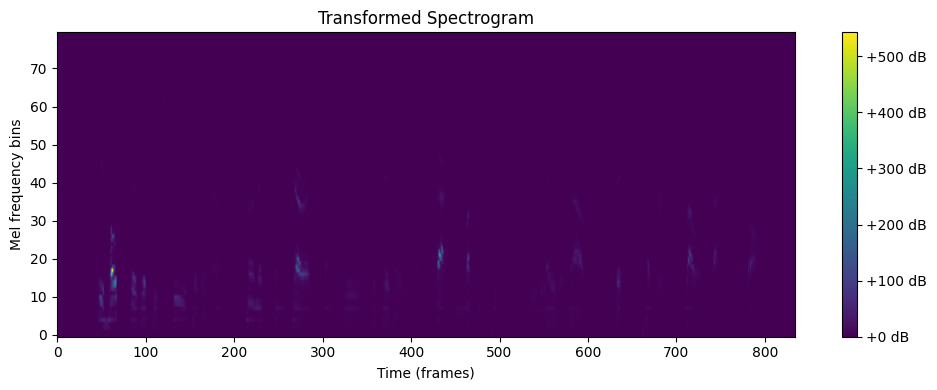

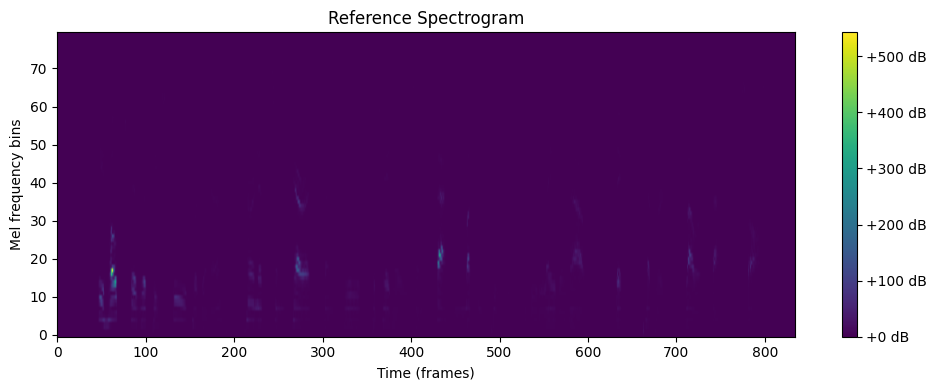

In [10]:
# Plot the first spectrogram
plot_spectrogram(spectrograms[0][0].numpy(), title="Transformed Spectrogram")
plot_spectrogram(example["spectrograms"][0][0].numpy(), title="Reference Spectrogram")

In [ ]:
mode = "recognize" # "train", "test", "recognize"
model_load = os.path.join(root_dir, 'epoch11.pth')
use_language_model = True
grid_search = False
wavfiles = [os.path.join(root_dir, 'LibriSpeech/test-clean/3729/6852/3729-6852-0004.flac'),
            os.path.join(root_dir, 'LibriSpeech/test-clean/8224/274384/8224-274384-0013.flac'),
            os.path.join(root_dir, 'LibriSpeech/test-clean/6930/75918/6930-75918-0019.flac'),
            ]
main(root_dir, mode, model_load, wavfiles, use_language_model=use_language_model, grid_search=grid_search)


Using device: cuda
don't download train
recognize
d:\Documents\GitHub\Speech_Speaker_Recognition\Assignements\lab4\epoch11.pth


UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 976: character maps to <undefined>